In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

for device in tf.config.list_physical_devices():
    print(device.name)

2026-02-20 09:25:19.546080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771579519.728095      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771579519.781189      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771579520.224351      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771579520.224401      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771579520.224404      24 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1
/physical_device:CPU:0
/physical_device:GPU:0



🚀 STARTING CENTRALIZED TRAINING


I0000 00:00:1771579545.347544      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/30


I0000 00:00:1771579551.828012      65 service.cc:152] XLA service 0x7c5694001600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771579551.828047      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771579552.761932      65 cuda_dnn.cc:529] Loaded cuDNN version 91002


  36/3318 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.4841

I0000 00:00:1771579557.653814      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3318/3318 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0459 - learning_rate: 0.0010
Epoch 2/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0153 - learning_rate: 0.0010
Epoch 3/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0142 - learning_rate: 0.0010
Epoch 4/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0136 - learning_rate: 0.0010
Epoch 5/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0132 - learning_rate: 0.0010
Epoch 6/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0129 - learning_rate: 0.0010
Epoch 7/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0128 - learning_rate: 0.0010
Epoch 8/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0127 - learning_rate: 0.0010
Epoch 9/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0125 - learning_rate: 0.0010
Epoch 10/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0125 - learning_rate: 0.0010
Epoch 11/30
3318/3318 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0123

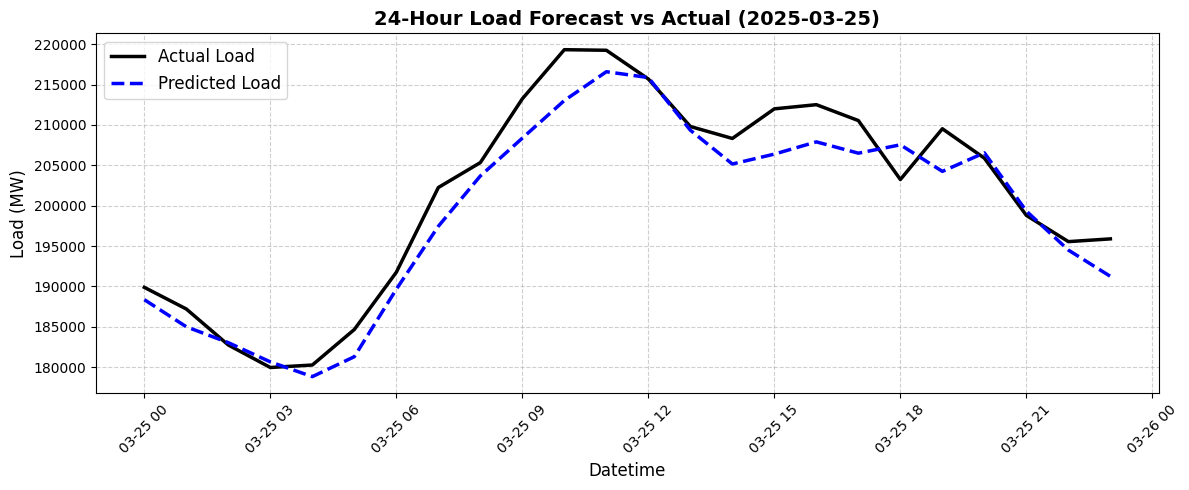

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

DATA_PATH = "/kaggle/input/datasets/samorion/india-complete-load-2001-2025/india_complete_load_2001_2025.csv"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "./INDIAmerged_hourly_load_weather.csv"

df = pd.read_csv(DATA_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

WINDOW = 24
TEST_START_DATE = "2025-03-25 00:00:00"
test_start_idx = df[df["datetime"] == TEST_START_DATE].index[0]

df_train = df.iloc[:test_start_idx].copy()
df_test = df.iloc[test_start_idx - WINDOW:].copy()

scaler = MinMaxScaler()
df_train["load_scaled"] = scaler.fit_transform(df_train[["load"]])
df_test["load_scaled"] = scaler.transform(df_test[["load"]])

def create_timeseries(data_array, window=24):
    X, y = [], []
    for i in range(window, len(data_array)):
        X.append(data_array[i-window:i])
        y.append(data_array[i])
    return np.array(X).reshape(-1, window, 1), np.array(y)

X_train, y_train = create_timeseries(df_train["load_scaled"].values, WINDOW)
X_test, y_test_scaled = create_timeseries(df_test["load_scaled"].values, WINDOW)
y_test_inv = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

def transformer_encoder(inputs, num_heads=4, ff_dim=128, dropout_rate=0.1):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=dropout_rate)(x, x)
    x = tf.keras.layers.Add()([inputs, attn])

    ff = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(inputs.shape[-1])
    ])
    
    x_ff = ff(tf.keras.layers.LayerNormalization(epsilon=1e-6)(x))
    return tf.keras.layers.Add()([x, x_ff])

def build_model(window=24):
    inputs = tf.keras.Input(shape=(window, 1))
    
    # Feature projection
    x = tf.keras.layers.Dense(32)(inputs)
    
    # Transformer Blocks
    x = transformer_encoder(x, num_heads=4, ff_dim=128, dropout_rate=0.1)
    x = transformer_encoder(x, num_heads=4, ff_dim=128, dropout_rate=0.1)
    
    # CRITICAL FIX: Reverted to Flatten to preserve time sequence
    x = tf.keras.layers.Flatten()(x) 
    
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    return model

BATCH_SIZE = 64
EPOCHS = 30 
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-5)
]

print("\n STARTING TRAINING")
with tf.device('/GPU:0'):
    model = build_model(WINDOW)
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    preds_scaled = model.predict(X_test, verbose=0)
    preds_inv = scaler.inverse_transform(preds_scaled)

mae = mean_absolute_error(y_test_inv, preds_inv)
mape = np.mean(np.abs((y_test_inv - preds_inv) / y_test_inv)) * 100
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
r2 = r2_score(y_test_inv, preds_inv)

print("\n" + "="*50)
print(f"PERFORMANCE METRICS FOR: {TEST_START_DATE[:10]}")
print("="*50)
print(f"MAE  : {mae:.2f} MW")
print(f"MAPE : {mape:.2f} %")
print(f"RMSE : {rmse:.2f} MW")
print(f"R²   : {r2:.4f}")
print("="*50)

print("\nGenerating 24-Hour Plot...")
test_timestamps = df_test["datetime"].iloc[WINDOW:].values

plt.figure(figsize=(12, 5))
plt.plot(test_timestamps, y_test_inv, label="Actual Load", color='black', linewidth=2.5)
plt.plot(test_timestamps, preds_inv, label="Predicted Load", color='blue', linestyle='--', linewidth=2.5)

plt.title(f"24-Hour Load Forecast vs Actual ({TEST_START_DATE[:10]})", fontsize=14, fontweight='bold')
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Load (MW)", fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("/kaggle/working/centralized_forecast.png", dpi=300)
plt.show()